# LSO Handin 2 - Subset Selection Problem

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyomo.environ as pyomo
from copy import copy
import random
from time import time

## Data Inspection

In [2]:
def get_data():
    df = pd.read_csv("CO2_economic.csv")
    X = df.drop(['CO2-GR', 'year'], axis=1).to_numpy()
    y = df['CO2-GR'].to_numpy()
    features = set(j for j in range(0, X.shape[1]))
    return df, X, y, features

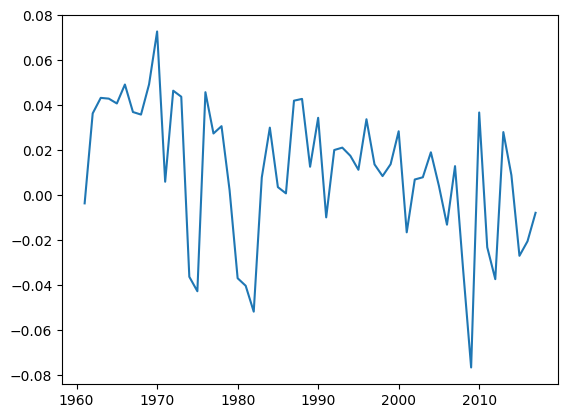

(57, 228)


,year,CO2-GR,FRED-MD-1,FRED-MD-2,FRED-MD-3,FRED-MD-4,FRED-MD-5,FRED-MD-6,FRED-MD-7,FRED-MD-8,...,US_Foreing_73,US_Foreing_74,US_Foreing_75,US_Foreing_76,US_CEMNT-1,US_CEMENT-2,US_TRANS-1,US_TRANS-2,US_TRANS-3,US_TRANS-4
0,1961,-0.003623,0.023464,-0.15530,-0.68443,-0.9180,-1.57080,-0.45069,-0.38606,-0.45797,...,0.716770,-0.60116,0.58925,-0.37866,-0.37213,-0.53299,-0.90675,-0.51371,-0.52343,-0.02997
1,1962,0.036385,0.985230,0.96994,0.93210,0.7986,0.43366,1.27100,1.31310,1.47760,...,-0.057105,0.23945,-0.52090,-0.17336,0.74256,0.65670,0.71695,-0.29572,0.12885,0.21633


In [6]:
df, X, y, features = get_data()

plt.plot(df['year'], df['CO2-GR'])
plt.show()

print(df.shape)
df.head(2)

In [7]:
def compute_beta(X, y, selected_features):

    selected_indicies = list(selected_features)

    X_k = X[:, selected_indicies]

    beta = np.zeros(shape=X.shape[1])
    beta_k, cost, *_ = np.linalg.lstsq(X_k, y, rcond=None)
    beta[selected_indicies] = beta_k

    # cost
    if len(cost) == 0:
        residuals = y - np.matmul(X_k, beta_k)
        cost = [np.dot(residuals, residuals)]

    return beta, cost[0]


def validate_solution(X, y, k, solution):
    # validate cost
    beta = solution['beta']
    residuals = y - X@beta
    cost = np.dot(residuals, residuals)
    assert np.allclose(cost, solution['cost']), 'Error in cost'

    # validate k
    assert beta[beta != 0].shape[0] <= k, f'Error in beta, {beta[beta != 0]} > {k}'

    # validate selected features
    assert len(solution['selected_features']) <= k, f"Error in selected features, {len(solution['selected_features'])} > {k}"


def plot_regression(df, X, y, solution):
    y_hat = X@solution['beta']
    residuals = y - y_hat

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

    ax[0].plot(df['year'], y, label='gt', color='blue')
    ax[0].plot(df['year'], y_hat, label='fit', color='red')
    ax[0].legend()
    ax[0].set_ylabel('CO2')
    ax[0].set_xlabel('Year')
    ax[0].set_title('Regression fit')

    ax[1].hlines(0, xmin=df['year'].min(), xmax=df['year'].max(), linestyle='dashed', color='black')
    ax[1].plot(df['year'], residuals, label='fit', color='black')
    ax[1].legend()
    ax[1].set_ylabel('Residual')
    ax[1].set_xlabel('Year')
    ax[1].set_title('Residuals')

    plt.show()

## Greedy LP solution

### LP-relaxation

In [8]:
def CP_model(X, y, k, LB, UB, solver, type):
    n = X.shape[0]
    p = X.shape[1]

    beta_list = list(range(1, p+1))

    if type == 'relaxation':
        z_type = pyomo.NonNegativeReals
    elif type == 'exact':
        z_type = pyomo.Binary
    else:
        raise ValueError

    lower_bound = [LB for j in beta_list]
    upper_bound = [UB for j in beta_list]

    model = pyomo.ConcreteModel()
    model.beta = pyomo.Var(beta_list, within=pyomo.Reals)
    model.z = pyomo.Var(beta_list, within=z_type, bounds=[0, 1])

    model.obj = pyomo.Objective(
        expr=sum([(y[i-1] - sum([X[i-1, j-1]*model.beta[j] for j in beta_list]))**2 for i in range(1, n+1)]),
        sense=pyomo.minimize
    )

    model.csts = pyomo.ConstraintList()
    model.csts.add(
        expr=sum([model.z[j] for j in beta_list]) <= k
    )
    for j in beta_list:
        model.csts.add(
            expr=lower_bound[j-1]*model.z[j] <= model.beta[j]
        )
        model.csts.add(
            expr=model.beta[j] <= upper_bound[j-1]*model.z[j]
        )

    solver.solve(model, tee=False)

    cost = pyomo.value(model.obj)
    beta = np.array([pyomo.value(model.beta[j]) for j in beta_list])
    z = np.array([pyomo.value(model.z[j]) for j in beta_list])

    return cost, beta, z

In [9]:
k = 10

try:
    solver = pyomo.SolverFactory('cplex', executable='/Applications/CPLEX_Studio2211/cplex/bin/arm64_osx/cplex')
    cost_CP, beta_CP, z_CP = CP_model(X=X, y=y, k=k, LB=-100, UB=100, solver=solver, type='relaxation')
except RuntimeError:
    solver = pyomo.SolverFactory('cplex')
    cost_CP, beta_CP, z_CP = CP_model(X=X, y=y, k=k, LB=-100, UB=100, solver=solver, type='relaxation')

print(cost_CP)

0.003287069183264541


### Greedy construction

In [10]:
def greedy_CP_solution(X, y, k, solver):
    # LP-relaxation
    cost_CP, beta_CP, z_CP = CP_model(X=X, y=y, k=k, LB=-100, UB=100, solver=solver, type='relaxation')

    # greedy choose features
    selected_features = set()
    order = np.argsort(z_CP)[::-1]

    for j in range(0, k):
        selected_features.add(int(order[j]))

    # evaluate
    beta, cost = compute_beta(X=X, y=y, selected_features=selected_features)

    output = {'beta':beta, 
              'cost':cost, 
              'selected_features':selected_features
    }
    return output

In [73]:
solution_greedy = greedy_CP_solution(X, y, k, solver)
validate_solution(X, y, k, solution_greedy)
print(solution_greedy['cost'])
print(solution_greedy['selected_features'])

0.027501652907703324
{99, 164, 100, 38, 49, 54, 183, 185, 126, 31}


### Random construction

In [11]:
def random_solution(X, y, k, features):
    # get k random features
    selected_features = set(random.sample(list(features), k=k))

    # estimate model
    beta, cost = compute_beta(X=X, y=y, selected_features=selected_features)

    output = {'beta':beta,
              'cost':cost,
              'selected_features':selected_features}
    
    return output

In [189]:
solution_random = random_solution(X=X, y=y, k=k, features=features)
print(solution_random['cost'])
print(solution_random['selected_features'])

0.02150970909923972
{34, 4, 5, 7, 104, 169, 41, 82, 179, 56}


## Iterated Local Search

### Local Search

In [12]:
def local_search(X, y, features, k, iteration_max, init, acceptance):
    assert acceptance in ['first', 'best'], 'local search acceptance criterion must be first or best'

    beta_initial = init['beta']
    cost_initial = init['cost']
    selected_features = init['selected_features']
    unselected_features = features.difference(selected_features)

    cost_best = copy(cost_initial)
    beta_best = copy(beta_initial)

    for iteration in range(1, iteration_max+1):
        breakout = False

        # search for a swap
        best_add = None
        best_remove = None
        for selected in selected_features:
            for unselected in unselected_features:
                # swap a selected and an unselected feature
                selected_new = copy(selected_features)
                selected_new.remove(selected)
                selected_new.add(unselected)
                
                beta_new, cost_new = compute_beta(X, y, selected_new)
                
                # save best solution
                if cost_new < cost_best:
                    cost_best = cost_new
                    best_add = unselected
                    best_remove = selected
                    beta_best = beta_new
                    if acceptance == 'first':
                        breakout = True
                
                if breakout:
                    break
            if breakout:
                break

        # accept, if no improvement then converge
        if best_add is not None and best_remove is not None:
            selected_features.remove(best_remove)
            selected_features.add(best_add)
        else:
            break
    
    output = {'beta':beta_best, 
              'cost':cost_best,
              'selected_features':selected_features,
              'iterations_LS':iteration
    }
    return output

In [331]:
k = 10
solution_greedy = greedy_CP_solution(X, y, k, solver)
validate_solution(X, y, k, solution_greedy)
print(solution_greedy['cost'])

solution_LS = local_search(X=X, y=y, features=features, k=k, iteration_max=100, init=solution_greedy, acceptance='best')
validate_solution(X, y, k, solution_LS)
print(solution_LS['cost'])
print(solution_LS['iterations_LS'])

0.027501652907703324
0.011005123407696833
12


### Iterated Local Search

In [13]:
def perturbation(features, selected_features, degree):
    assert degree <= len(selected_features), f'Pertubation degree {degree} is larger than size of selection features {len(selected_features)}'

    # get unselected features
    unselected_features = features.difference(selected_features)

    # get features to remomve and add
    features_to_remove = set(random.sample(list(selected_features), k=degree))
    features_to_add = set(random.sample(list(unselected_features), k=degree))

    # perturbation
    perturbed_features = copy(selected_features)
    perturbed_features = perturbed_features.difference(features_to_remove)
    perturbed_features = perturbed_features.union(features_to_add)

    return perturbed_features

In [ ]:
def ILS(X, y, k, features, init, iteration_ILS, iteration_LS, initial_degree, fallback_degree, acceptance, debug=True):
    # if initial solution cost already as small as we can handle
    if init['cost'] <= np.finfo(float).eps:
        init['cost'] = 0
        return init
    
    init = local_search(X=X, y=y, features=features, k=k, 
                        iteration_max=iteration_LS, 
                        init=init, 
                        acceptance=acceptance)

    # initialize best solution
    solution_best = copy(init)
    iteration_update = 0

    # initialize current solution that will move around 
    solution_current = copy(init)
    degree = copy(initial_degree)

    for iteration in range(1, iteration_ILS+1):
        selected_features_perturbed = perturbation(features=features, 
                                                   selected_features=solution_current['selected_features'], 
                                                   degree=degree)

        beta_perturbed, cost_perturbed = compute_beta(X=X, y=y, 
                                                      selected_features=selected_features_perturbed)
        solution_perturbed = {'beta':beta_perturbed, 
                              'cost':cost_perturbed, 
                              'selected_features':selected_features_perturbed
        }
        
        solution_LS = local_search(X=X, y=y, features=features, k=k, 
                                   iteration_max=iteration_LS, 
                                   init=solution_perturbed,
                                   acceptance=acceptance)

        # update best solution
        if solution_LS['cost'] < solution_best['cost']:
            solution_best = solution_LS
            iteration_update = iteration
            degree = fallback_degree # intensify search
        
        # acceptance of new solution if better or no improvment for number of iterations
        if solution_LS['cost'] < solution_current['cost'] or iteration - iteration_update >= 5:
            solution_current = solution_LS

            if iteration - iteration_update >= 5:
                degree = min(k, degree+1) # diversify search
                iteration_update = iteration

        if debug:
            print(f'{iteration}, degree={degree}, LS={solution_LS['cost']}, current={solution_current['cost']}, best={solution_best['cost']}')

    return solution_best

In [27]:
k = 20
solution_greedy = greedy_CP_solution(X, y, k=k, solver=solver)
validate_solution(X, y, k, solution_greedy)
print(solution_greedy['cost'])

start_time = time()
solution_ILS = ILS(X=X, y=y, k=k, features=features, init=solution_greedy, iteration_ILS=100, iteration_LS=100, initial_degree=1, fallback_degree=2, acceptance='first')
end_time = time()
validate_solution(X, y, k, solution_ILS)
print(solution_ILS['cost'])
print(f'Time: {round(end_time-start_time, 2)}')

start_time = time()
solution_ILS = ILS(X=X, y=y, k=k, features=features, init=solution_greedy, iteration_ILS=100, iteration_LS=100, initial_degree=1, fallback_degree=2, acceptance='best')
end_time = time()
validate_solution(X, y, k, solution_ILS)
print(solution_ILS['cost'])
print(f'Time: {round(end_time-start_time, 2)}')

0.01989405573483135
1, degree=2, LS=0.007242761699915649, current=0.007242761699915649, best=0.007242761699915649
2, degree=2, LS=0.007152324068051441, current=0.007152324068051441, best=0.007152324068051441
3, degree=2, LS=0.007205860742358055, current=0.007152324068051441, best=0.007152324068051441
4, degree=2, LS=0.007311600116036009, current=0.007152324068051441, best=0.007152324068051441
5, degree=2, LS=0.007342777822657712, current=0.007152324068051441, best=0.007152324068051441
6, degree=2, LS=0.007357791147568392, current=0.007152324068051441, best=0.007152324068051441
7, degree=2, LS=0.007078907122832613, current=0.007078907122832613, best=0.007078907122832613
8, degree=2, LS=0.007239981509394324, current=0.007078907122832613, best=0.007078907122832613
9, degree=2, LS=0.0073114077166635235, current=0.007078907122832613, best=0.007078907122832613
10, degree=2, LS=0.006952254803163378, current=0.006952254803163378, best=0.006952254803163378
11, degree=2, LS=0.00723108368269293, 

In [ ]:
costs_random = []
costs_greedy = []
costs_ILS = []
time_ILS = []
k_values = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 25, 30, 35, 40, 45, 50]

for k in k_values:
    acceptance = 'best' #if k <= 10 else 'first'

    solution_random = random_solution(X, y, k, features)
    validate_solution(X, y, k, solution_random)
    costs_random.append(solution_random['cost'])

    solution_greedy = greedy_CP_solution(X, y, k=k, solver=solver)
    validate_solution(X, y, k, solution_greedy)
    costs_greedy.append(solution_greedy['cost'])

    start_time = time()
    solution_ILS = ILS(X=X, y=y, k=k, features=features, 
                       init=solution_greedy, iteration_ILS=100, iteration_LS=100, 
                       initial_degree=1, fallback_degree=2, acceptance=acceptance, debug=False)
    end_time = time()
    validate_solution(X, y, k, solution_ILS)
    costs_ILS.append(solution_ILS['cost'])
    time_ILS.append(end_time-start_time)

    print(f'k: {k}, random cost: {solution_random['cost']}, greedy cost: {solution_greedy['cost']}, ILS cost: {solution_ILS['cost']}, time: {round(end_time-start_time, 3)}')

k: 25, random cost: 0.014292401249249225, greedy cost: 0.018439431295822612, ILS cost: 0.006526930357355918, time: 180.707
k: 30, random cost: 0.01432876844683976, greedy cost: 0.012634343208066072, ILS cost: 0.0063926619227931206, time: 349.627


KeyboardInterrupt: 

k: 2, random cost: 0.04214079499120297, greedy cost: 0.05370251605311049, ILS cost: 0.020154083296846616, time: 1.321

k: 4, random cost: 0.03857259230453209, greedy cost: 0.048930264603997915, ILS cost: 0.016293876911925492, time: 4.687

k: 6, random cost: 0.037984361742818246, greedy cost: 0.03340849938666939, ILS cost: 0.01323339079835831, time: 9.736

k: 8, random cost: 0.02956295237141276, greedy cost: 0.030307466457335556, ILS cost: 0.011596358739829364, time: 15.155

k: 10, random cost: 0.03553438135169497, greedy cost: 0.027501652907702862, ILS cost: 0.010061128915661514, time: 28.347

k: 12, random cost: 0.023730500212509612, greedy cost: 0.026132586149058723, ILS cost: 0.00914807071454847, time: 42.48

k: 14, random cost: 0.022767131534363376, greedy cost: 0.025071028047171758, ILS cost: 0.00814291396756936, time: 45.937

k: 16, random cost: 0.027378447914688048, greedy cost: 0.020587648667360903, ILS cost: 0.007535129972605452, time: 82.486

k: 18, random cost: 0.021742295822482986, greedy cost: 0.019968958170254885, ILS cost: 0.0073938032902379535, time: 72.915

k: 20, random cost: 0.020310833008590094, greedy cost: 0.01989405573483135, ILS cost: 0.007151239474939557, time: 89.062

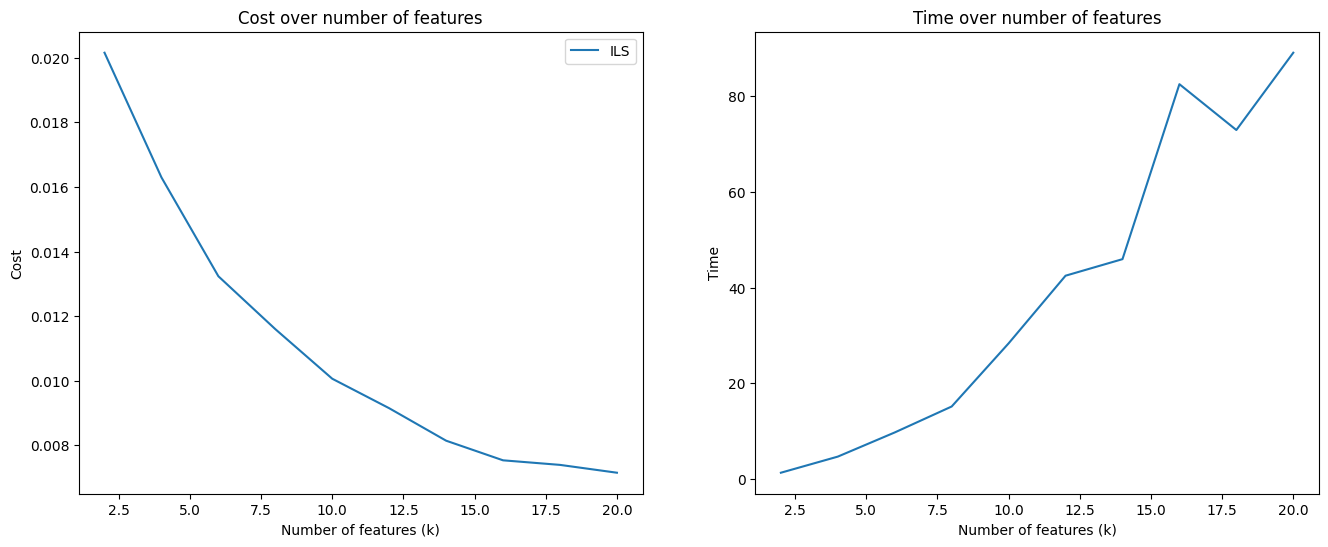

In [36]:

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

#ax[0].plot(k_values, costs_random, label='Random')
#ax[0].plot(k_values, costs_greedy, label='Greedy')
ax[0].plot(k_values, costs_ILS, label='ILS')
ax[0].legend()
ax[0].set_ylabel('Cost')
ax[0].set_xlabel('Number of features (k)')
ax[0].set_title('Cost over number of features')

ax[1].plot(k_values, time_ILS)
ax[1].set_ylabel('Time')
ax[1].set_xlabel('Number of features (k)')
ax[1].set_title('Time over number of features')

plt.show()